In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import torch
import volatility_clustering as vol_clust

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

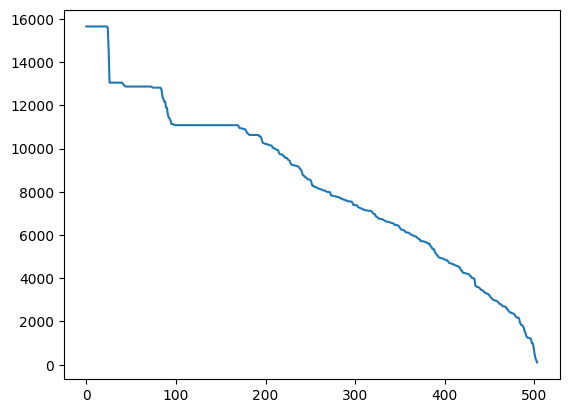

In [4]:
N_STOCKS = 9216
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= N_STOCKS].index

In [5]:
# stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['MSFT']
first_date = real_data.index[-N_STOCKS]
real_data = real_data.loc[first_date:, stocks]
real_data = real_data.loc[:, np.all(~np.isnan(real_data), axis=0)]
assert np.all(~np.isnan(real_data))
print(f"Shape: {real_data.shape}")
print(f"Frist Date {real_data.index[0]:%Y-%m-%d}")
print(f"Last Date {real_data.index[-1]:%Y-%m-%d}")

Shape: (9216, 233)
Frist Date 1987-08-05
Last Date 2024-03-01


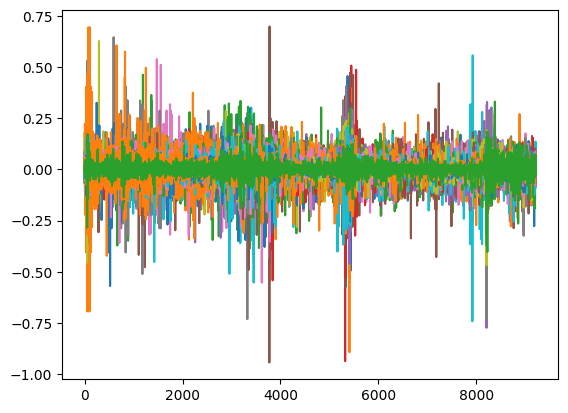

In [6]:
np_data = np.array(real_data)
np_ret = np.log(np_data[1:] / np_data[:-1])
np_ret[np.abs(np_ret) >= 2] = 0  # clean data
np_log_price = np.cumsum(np_ret, axis=0)
plt.plot(np_ret)
plt.show()

Max fit x 150, min fit x 0.07883157751053964
alpha : -1.0313682069531553
beta -0.30117407015928177
Beta std 0.11133956231850263
corr std 0.040029014080181426


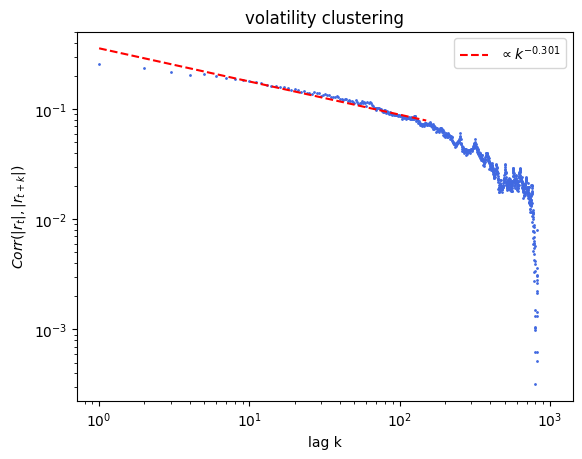

In [7]:
stat = vol_clust.volatility_clustering_stats(log_returns=np_ret, max_lag=1000)
pos_y, x_lin, alpha, beta, r = (
    np.mean(stat["vol_clust"], axis=1),
    stat["power_fit_x"],
    stat["const"],
    stat["rate"],
    stat["corr"],
)
beta_std, corr_std = stat["rate_std"], stat["corr_std"]
pos_x = np.arange(1, pos_y.size + 1)
y_lin = np.exp(alpha) * np.power(x_lin, beta)
plt.gca().set(**vol_clust.vol_clust_axes_setting)
plt.plot(pos_x, pos_y, **vol_clust.vol_clust_plot_setting)
plt.plot(
    x_lin,
    y_lin,
    label=f"$\propto k^{{{beta:.3f}}}$",
    linestyle="--",
    color="red",
    alpha=1,
)
print(f"Max fit x {np.max(x_lin)}, min fit x {np.min(y_lin)}")
print(f"alpha : {alpha}")
print(f"beta {beta}")
print(f"Beta std {beta_std}")
print(f"corr std {corr_std}")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/vc.png")
plt.show()